In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
np.random.seed(20)

In [2]:
X, Y = make_classification(n_samples=1000, n_classes=2, n_informative=2, n_features=4)
X = X.reshape(X.shape[1], X.shape[0])
Y = Y.reshape(1, -1)
print(X.shape, Y.shape)

(4, 1000) (1, 1000)


In [3]:
X = (X - np.mean(X, axis=1, keepdims=True)) / np.std(X, axis=1, keepdims=True)

In [4]:
layer_dims = [4, 3, 2, 1]

In [5]:
def initialize_parameters_deep(layer_dims):
    parameters = {}
    L = len(layer_dims)
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l - 1]) * 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))

    return parameters 

In [6]:
parameters = initialize_parameters_deep(layer_dims)
for item in parameters.items():
    print(f'{item[0]} -- {item[1].shape}')

W1 -- (3, 4)
b1 -- (3, 1)
W2 -- (2, 3)
b2 -- (2, 1)
W3 -- (1, 2)
b3 -- (1, 1)


In [7]:
def linear_forward(A_prev, W, b):

    Z = np.dot(W, A_prev) + b

    cache = (A_prev, W, b)

    return Z, cache

In [8]:
Z, cache = linear_forward(X, parameters['W1'], parameters['b1'])
print(Z.shape)
print(cache)

(3, 1000)
(array([[-0.33551359,  0.57533717,  0.99525765, ..., -0.51885372,
         1.20422516,  0.56733525],
       [-0.43235651,  0.70628803,  1.27028294, ..., -0.76507611,
        -1.3833381 ,  1.54162087],
       [-0.12440797,  0.47128951,  0.23481807, ...,  0.8018289 ,
        -0.39377106, -1.12904964],
       [-0.52578603,  0.7787923 ,  1.50874935, ..., -0.60063799,
         2.13096613,  0.42064651]]), array([[-0.00106857,  0.00630043,  0.00157366,  0.01856362],
       [ 0.00665667,  0.00562417, -0.00630879, -0.01441879],
       [ 0.01449388,  0.0100859 ,  0.00597207,  0.0142919 ]]), array([[0.],
       [0.],
       [0.]]))


In [9]:
def sigmoid(Z):
    A = 1 / (1 + np.exp(-Z))

    return A, Z

In [10]:
def relu(Z):
    A = np.maximum(0.0, Z)

    return A, Z

In [11]:
def tanh(Z):
    A = np.tanh(Z)

    return A, Z

In [12]:
def linear_activation_forward(A_prev, W, b, activation):

    if activation == 'sigmoid':
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)

    elif activation == 'tanh':
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = tanh(Z)
    
    elif activation == 'relu':
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)

    cache = (linear_cache, activation_cache)

    return A, cache 

In [13]:
A, cache = linear_activation_forward(X, parameters['W1'], parameters['b1'], 'relu')
print(A.shape)

(3, 1000)


In [14]:
def L_model_forward(X, parameters):
    
    caches = []
    A = X

    L = len(parameters) // 2

    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], 'relu')
        caches.append(cache)


    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], 'sigmoid')
    caches.append(cache)

    return AL, caches

In [15]:
def compute_cost(Y, AL, lambd=0, parameters=None, eps=1e-12):

    m = Y.shape[1]

    regularization_cost = 0

    if parameters != None:
        for key, value in parameters.items():
            if(key[0] == 'W'):
                regularization_cost += np.squeeze(np.sum(np.square(value)))
    
    regularization_cost *= lambd / (2 * m)

    cost = -1/m * np.sum((Y*np.log(AL + eps) + (1 - Y)*np.log(1 - AL + eps))) +  regularization_cost
    return np.squeeze(cost)

In [16]:
AL, caches = L_model_forward(X, parameters)
cost = compute_cost(Y, AL, lambd=0, parameters=parameters)
print(cost)

0.6931471941244716


In [17]:
def linear_backward(dZ, cache, lambd=0):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1/m * np.dot(dZ, A_prev.T) + (lambd/m) * W
    db = 1/m * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)

    return dA_prev, dW, db

In [18]:
def relu_backward(dA, activation_cache):
    Z = activation_cache
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0
    return dZ

In [19]:
def tanh_backward(dA, activation_cache):
    Z = activation_cache
    return dA * (1 - np.tanh(Z) ** 2)

In [20]:
def sigmoid_backward(dA, activation_cache):
    Z = activation_cache
    A = 1 / (1 + np.exp(-Z))
    return dA * A * (1 - A)

In [21]:
def linear_activation_backward(dA, cache, activation, lambd=0):

    linear_cache, activation_cache = cache

    if activation == 'tanh':
        dZ = tanh_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache, lambd)

    elif activation == 'sigmoid':
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache, lambd)

    elif activation == 'relu':
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache, lambd)

    return dA_prev, dW, db

In [22]:
def L_model_backward(AL, Y, caches, lambd=0, eps=1e-12):
    dAL = - (np.divide(Y, AL + eps) - np.divide((1 - Y), (1 - AL + eps)))
    Y = Y.reshape(AL.shape)
    L = len(caches)

    grads = {}
    current_cache = caches[L - 1]
    dA_prev, dW, db = linear_activation_backward(dAL, current_cache, 'sigmoid', lambd)
    grads['dA' + str(L - 1)] = dA_prev
    grads['dW' + str(L)] = dW
    grads['db' + str(L)] = db

    for l in reversed(range(L - 1)):
        current_cache = caches[l]
        dA_prev, dW, db = linear_activation_backward(dA_prev, current_cache, 'relu', lambd)
        grads['dA' + str(l)] = dA_prev
        grads['dW' + str(l + 1)] = dW
        grads['db' + str(l + 1)] = db


    return grads



In [23]:
def update_parameters(parameters, grads, learning_rate=0.001):

    L = len(parameters) // 2

    for l in range(L):
        parameters['W' + str(l + 1)] -= learning_rate * grads['dW' + str(l + 1)]
        parameters['b' + str(l + 1)] -= learning_rate * grads['db' + str(l + 1)]


    return parameters

    

In [24]:
parameters = initialize_parameters_deep(layer_dims)
AL, caches = L_model_forward(X, parameters)
print(compute_cost(Y, AL))
grads = L_model_backward(AL, Y, caches)
parameters = update_parameters(parameters, grads)
AL, caches = L_model_forward(X, parameters)
print(compute_cost(Y, AL))
grads = L_model_backward(AL, Y, caches)
parameters = update_parameters(parameters, grads)
AL, caches = L_model_forward(X, parameters)
print(compute_cost(Y, AL))

0.6931471797502086
0.6931471797394463
0.6931471797300177


In [25]:
def L_layer_model(X, Y, parameters, lambd=0, learning_rate=0.01, num_iterations=1000, print_cost=False):
    costs = []
    for i in range(num_iterations):
        AL, caches = L_model_forward(X, parameters)
        cost = compute_cost(AL, Y, lambd)
        grads = L_model_backward(AL, Y, caches, lambd)
        parameters = update_parameters(parameters, grads, learning_rate)

        if print_cost and (i % 100 == 0 or i == num_iterations - 1):
            print(f"Cost after iteration {i}: {np.squeeze(cost):.4f}")
        if i % 100 == 0:
            costs.append(cost)

    return parameters, costs

In [26]:
def initialize_with_zeros(layer_dims):
    params = {}
    L = len(layer_dims)
    for l in range(1, L):
        params['W' + str(l)] = np.zeros((layer_dims[l], layer_dims[l - 1]))
        params['b' + str(l)] = np.zeros((layer_dims[l], 1))

    return params

Cost after iteration 0: 13.8155
Cost after iteration 100: 13.8155


Cost after iteration 200: 13.8155
Cost after iteration 300: 13.8155
Cost after iteration 400: 13.8155
Cost after iteration 500: 13.8155
Cost after iteration 600: 13.8155
Cost after iteration 700: 13.8155
Cost after iteration 800: 13.8155
Cost after iteration 900: 13.8155
Cost after iteration 999: 13.8155


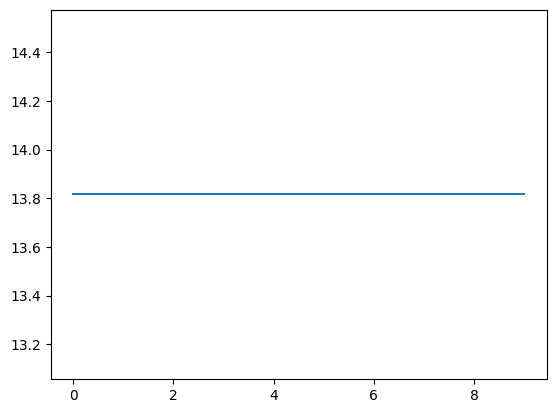

In [27]:
params = initialize_with_zeros(layer_dims)
params, costs = L_layer_model(X, Y, params, print_cost=True)
plt.plot(range(len(costs)), costs)
plt.show()

Cost after iteration 0: 13.8155
Cost after iteration 100: 13.8155
Cost after iteration 200: 13.8155
Cost after iteration 300: 13.8155
Cost after iteration 400: 13.8155
Cost after iteration 500: 13.8155
Cost after iteration 600: 13.8155
Cost after iteration 700: 13.8155
Cost after iteration 800: 13.8155
Cost after iteration 900: 13.8155
Cost after iteration 999: 13.8155


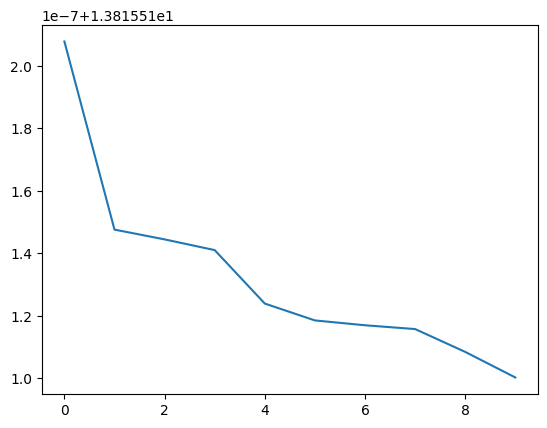

In [28]:
params = initialize_parameters_deep(layer_dims)
params, costs = L_layer_model(X, Y, params, print_cost=True)
plt.plot(range(len(costs)), costs)
plt.show()

In [29]:
def He_initialization(layer_dims):
    params = {}
    L = len(layer_dims)
    for l in range(1, L):
        params['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l - 1]) * np.sqrt(2/ layer_dims[l - 1])
        params['b' + str(l)] = np.zeros((layer_dims[l], 1))

    return params

Cost after iteration 0: 13.6500
Cost after iteration 100: 13.7279
Cost after iteration 200: 13.7605
Cost after iteration 300: 13.7715
Cost after iteration 400: 13.7756
Cost after iteration 500: 13.7775
Cost after iteration 600: 13.7786
Cost after iteration 700: 13.7794
Cost after iteration 800: 13.7801
Cost after iteration 900: 13.7814
Cost after iteration 999: 13.7825


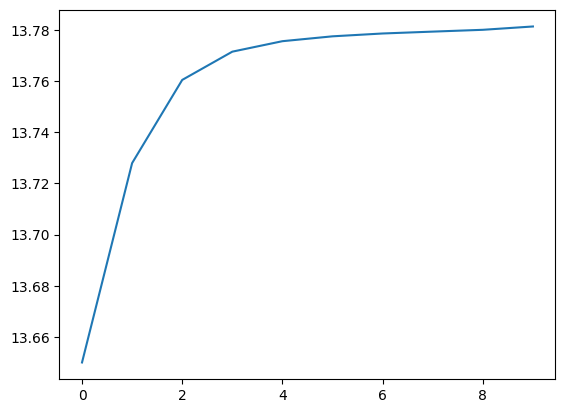

In [412]:
params = He_initialization(layer_dims)
params, costs = L_layer_model(X, Y, params, print_cost=True)
plt.plot(range(len(costs)), costs)
plt.show()